### Importing Necessary Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading and loading CSV file

In [29]:
df=pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Exploration

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [31]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [32]:
df.duplicated().sum()

415

In [33]:
df.drop_duplicates(inplace=True)

In [34]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4516   4516  Go until jurong point, crazy.. Available only ...   
spam         641    641  Free entry in 2 a wkly comp to win FA Cup fina...   

               
         freq  
Category       
ham         1  
spam        1

In [35]:
df['Message'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

### Importing Libraries for text preprocessing

In [36]:
import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vamsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
df["Process_message"] = df["Message"].apply(clean)

### Text after preprocessing

In [38]:
df.head()

,Category,Message,Process_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


### Import libraries for tokenizing and sequencing

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Tokenize and sequence the text

In [40]:
def tf_processing(corpus):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    
    total_words = len(tokenizer.word_index) + 1
    maxlen = max([len(x) for x in sequences])
    sequences = pad_sequences(sequences, maxlen=maxlen)

    return sequences, total_words, maxlen

In [41]:
x, total_words, maxlen = tf_processing(df['Process_message'])
y = df['Category'].replace({'ham':0, 'spam':1})

In [42]:
x

array([[   0,    0,    0, ...,   16, 2905,   68],
       [   0,    0,    0, ...,  321,    1, 1382],
       [   0,    0,    0, ...,   40, 2907,  311],
       ...,
       [   0,    0,    0, ..., 1362, 6847, 1231],
       [   0,    0,    0, ...,  741,  139,   15],
       [   0,    0,    0, ..., 1846,  411,  188]])

In [43]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: Category, Length: 5157, dtype: int64

### Splitting the Data into Train and test

In [44]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.25)

### Building the model

In [45]:
from tensorflow.keras import layers, Model, Input, optimizers, callbacks

In [46]:
# Define input layer with shape (maxlen,)

inputs = Input(shape=(maxlen,))

# Add an Embedding layer to learn word embeddings
# total_words: Size of the vocabulary, i.e., total number of unique words
# 100: Dimensionality of the embedding space, i.e., each word represented by a vector of size 100
# input_length: Length of the input sequences

embedding = layers.Embedding(total_words, 100, input_length=maxlen)(inputs)

# Add a Bidirectional LSTM layer
# Bidirectional LSTM processes input sequences in both forward and backward directions
# 128: Dimensionality of the output space, i.e., number of units in the LSTM layer

x = layers.Bidirectional(layers.LSTM(128))(embedding)


# Add a Dense layer with ReLU activation function
# 256: Number of units in the dense layer
# 'relu': Rectified Linear Unit activation function

x = layers.Dense(256, activation='relu')(x)

# Add a Dense layer with Sigmoid activation function for binary classification
# 1: Output layer with single unit for binary classification (e.g., spam or not spam)
# 'sigmoid': Sigmoid activation function to output probability in the range [0, 1]
x = layers.Dense(1, activation='sigmoid')(x)

# Create a Model by specifying inputs and outputs
model = Model(inputs=inputs, outputs=x)

# Compile the model
# 'binary_crossentropy': Loss function for binary classification tasks
# optimizers.Adam(0.0001): Adam optimizer with learning rate of 0.0001
# ['accuracy']: Evaluation metric to monitor during training

model.compile(loss='binary_crossentropy',
              optimizer = optimizers.Adam(0.0001),
              metrics=['accuracy'])



### Make callback after accuracy reaches above 99%

In [47]:
class myCallback(callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            self.model.stop_training =True

In [48]:
callback = myCallback()
history = model.fit(x_train, y_train,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=callback)

Epoch 1/100
121/121 [==============================] - 37s 243ms/step - loss: 0.4205 - accuracy: 0.8795 - val_loss: 0.3545 - val_accuracy: 0.8643
Epoch 2/100
121/121 [==============================] - 27s 223ms/step - loss: 0.2476 - accuracy: 0.9004 - val_loss: 0.2116 - val_accuracy: 0.9302
Epoch 3/100
121/121 [==============================] - 27s 222ms/step - loss: 0.1175 - accuracy: 0.9716 - val_loss: 0.1103 - val_accuracy: 0.9690
Epoch 4/100
121/121 [==============================] - 25s 208ms/step - loss: 0.0552 - accuracy: 0.9842 - val_loss: 0.0750 - val_accuracy: 0.9760
Epoch 5/100
121/121 [==============================] - 226s 2s/step - loss: 0.0349 - accuracy: 0.9899 - val_loss: 0.0662 - val_accuracy: 0.9822
Epoch 6/100
121/121 [==============================] - 16s 134ms/step - loss: 0.0257 - accuracy: 0.9928 - val_loss: 0.0672 - val_accuracy: 0.9791


Text(0.5, 1.0, 'loss')

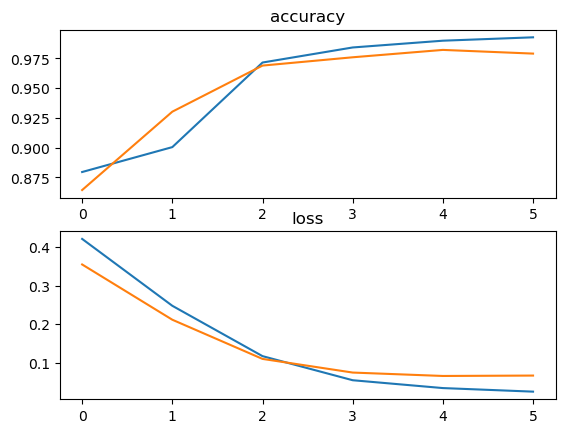

In [49]:
fig, ax = plt.subplots(2)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('accuracy')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('loss')

### Test Dataset

In [52]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

41/41 [==============================] - 1s 28ms/step - loss: 0.0672 - accuracy: 0.9791
Test Loss: 0.067230224609375
Test Accuracy: 0.9790697693824768
